# Dependence Modelling between Financial Assets

In this notebook we will examine how to model two financial assets simultaneously. In doing so, we must have a model for each asset's return respectivley, and a method to combine these (univariate) models. We will use the EUR/USD and NOK/USD currencies as our assets. There will be ten years of weekly data, going back to 2011. Since we are modelling returns, we will calculate the log-returns of the assets' price histories. 

The univariate model for each asset will be a no-mean GARCH(1,1) model, described below:
$$
r_t = \sigma_t \xi_t, \quad \xi_t \sim N(0,1)
$$

$$
\sigma_t^2 = \omega + \alpha r_{t-1}^2 + \beta \sigma_{t-1}^2
$$

The multivariate model between the two assets will be created from a range of copulas. Copulas are multivariate tools (in fact distributions) which may be used to combine multiple univariate distributions into one multivariate distribution. 

Before we create a multivariate model however, we will examine a couple of useful correlation measures.

**_The goal is to be able to model the dependency between the assets. This allows us to e.g. Monte Carlo simulate both assets more accurately._**

---



### Introduction, Data Preparation and Visualization

The data is fetched from Yahoo! Finance again, and similar to before the log returns are calculated.

In [60]:
import numpy as np
from pandas_datareader import data as pdr

# Weekly data
eur_weekly = pdr.get_data_yahoo("EURUSD=X", start="2011-12-28", end="2021-12-28", interval="wk")
eur_weekly = eur_weekly["Adj Close"]
nok_weekly = pdr.get_data_yahoo("NOKUSD=X", start="2011-12-28", end="2021-12-28", interval="wk")
nok_weekly = nok_weekly["Adj Close"]

# Log Returns
eur_weekly_returns = np.log(eur_weekly / eur_weekly.shift(1))[1:]
nok_weekly_returns = np.log(nok_weekly / nok_weekly.shift(1))[1:]

In [64]:
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
from matplotlib import pyplot as plt

sns.set_theme()
sns.set_style("whitegrid", {'grid.linestyle': '--'})
seq_col_brew = sns.color_palette("flag_r", 4)
sns.set_palette(seq_col_brew)

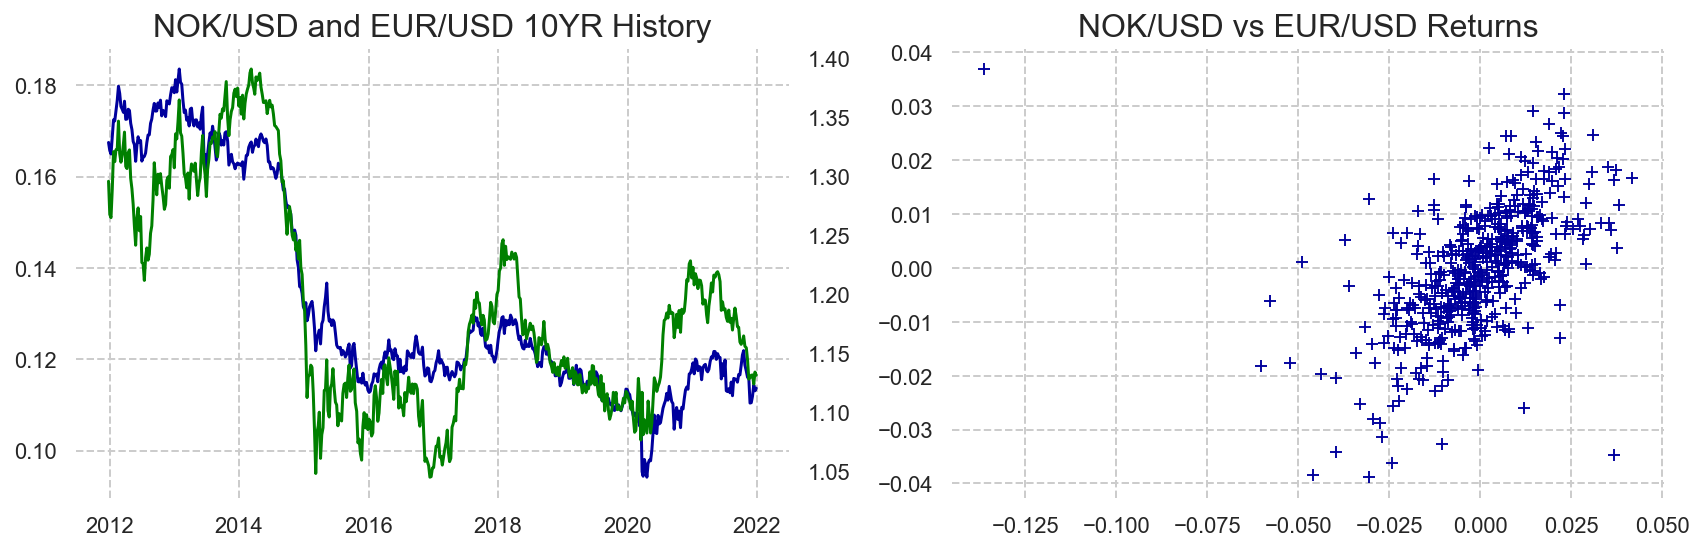

In [748]:
fig, axs = plt.subplots(1, 2)

axs[0].plot(nok_weekly, label='NOK/USD')
ax2 = axs[0].twinx()
ax2.plot(eur_weekly, color='green', label='EUR/USD') 
ax2.grid(False)

axs[0].tick_params(left = False)
ax2.tick_params(right = False)

axs[0].set_frame_on(False)
ax2.set_frame_on(False)
axs[0].set_title('NOK/USD and EUR/USD 10YR History', fontsize=16)


axs[1].scatter(nok_weekly_returns, eur_weekly_returns, marker='+', linewidths=0.95)
axs[1].set_frame_on(False)
axs[1].set_title('NOK/USD vs EUR/USD Returns', fontsize=16)

fig.set_size_inches(12, 4)
plt.tight_layout()
plt.show()

We can visually observe a high correlation between the two assets. This supports the idea that a multivariate model is required to capture both assets' price movements simultaneously. If they were uncorrelated, univariate models would suffice, since the sampling form their distributions would already be independent.

---

### Correlation and Autocorrelation 

In order to quantify the aforementioned correlation we look at three primary correlation measures:

* Pearson's Rho
* Spearman's Rank Correlation
* Kendall's Tau

Each of these measures tries to capture the co-movement of two data sets. TODO: Add remaining correlation coefficients.

#### Pearson's Rho
This is the most common correlation measure, which is most typically refered to when talking about correlation. The sample correlation estimator follows below. This number can be a good start when trying to fit many copulas which depend on the correlation coefficient!

$$\hat{\rho} = \frac{\sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^n (x_i-\bar{x})\sum_{i=1}^n (y_i-\bar{y})}}$$

In [758]:
corr_eur_nok = np.corrcoef(eur_weekly_returns, nok_weekly_returns)[0,1]
corr_eur_nok

0.5308025410988915

#### Autocorrelation

This measures the correlation between two stochastic variables from the same stochastic process (time series in this case). It is defined by the expression below. Since this expression is hard to evaluate, stationarity is usually assumed. This implies the second expression.

$$\textrm{corr}(X_t, X_{s}) = \frac{\mathbb{E}[X_tX_s]}{\sigma_t\sigma_s}$$

$$\textrm{corr}(X_t, X_{s}) = \frac{\mathbb{E}[X_tX_s]}{\sigma^2}$$

Finally, estimation of the autocorrelation is done by a sample autocorrelation estimator, this is presented below.

$$\frac{1}{(t-k)\sigma^2} \sum_{i=1}^{t-k}(x_i-\bar{x})(x_{i+k} - \bar{x})$$

---

### Model for Returns and Volatility for the EUR and NOK

As previously, we model each asset's returns by a no-mean GARCH(1,1) model. This model is described below.

$$ r_t = \sigma_t \xi_t, \quad \xi_t \sim N(0, 1)$$
$$ \sigma_t^2 = \omega + \alpha r_{t-1}^2 + \beta \sigma_{t-1}^2$$

For each asset we will have to Maximum Likelihood Estimate the parameters of the GARCH(1,1) process, and then examine how well the model fits the data by looking at QQ-plots.

In [711]:
from scipy import stats

def log_likelihood_garch(param, data):
    # param[0] is omega
    # param[1] is alpha
    # param[2] is beta
    log_likelihood = 0
    vol_est = param[0] + param[1] * (data[1] ** 2) + param[2] * (data[0] ** 2)
    n_observations = len(data)

    for i in range(1, n_observations):
        log_likelihood = log_likelihood + (np.log(vol_est) + (data[i] ** 2) / vol_est)
        vol_est = param[0] + param[1] * (data[i] ** 2) + param[2] * vol_est
        
    return log_likelihood

def GARCH_annualized(data, omega, alpha, beta, measurement_time):
    n_observations = len(data)
    vol_est = np.sqrt(omega + alpha * (data[0] ** 2) + beta * (data[0] ** 2))
    vol = []
    for i in range(1, n_observations):
        vol.append(vol_est)
        vol_est = np.sqrt(omega + alpha * (data[i] ** 2) + beta * (vol_est ** 2))
    vol_annual = [x * np.sqrt(1/measurement_time) for x in vol]
    return vol_annual

def qq_plot_normal(data, title, ax):
    observations = data
    observations.sort()
    n_observations = len(observations)

    empirical_quantiles = observations
    theoretical_quantiles = [stats.norm.ppf((i - 0.5)/n_observations) for i in range(1, n_observations + 1)]

    ## qq-line (y = mx + b) based on the 25th and 75th quantile of each distribtuion. 
    (x1, x2) = stats.norm.ppf((0.25, 0.75))
    (y1, y2) = np.quantile(observations, (0.25, 0.75))

    slope = (y2 - y1)/(x2 - x1)
    intercept = y2 - (slope * x2)
    qqrange = np.linspace(theoretical_quantiles[0], theoretical_quantiles[-1])
    qqline = [slope * x + intercept for x in qqrange]

    plot = ax.plot(qqrange, qqline, linestyle='dashdot', color='red')
    plot = ax.scatter(theoretical_quantiles, empirical_quantiles, marker='+', linewidths=0.75, zorder=2)
    ax.set_title(title)
    ax.set_frame_on(False)

    return plot

In [721]:
import warnings
warnings.filterwarnings("ignore")

cons_garch = [{'type': 'ineq', 'fun': lambda x:  -x[1] - x[2] + 1},
              {'type': 'ineq', 'fun': lambda x:  x[0]},
              {'type': 'ineq', 'fun': lambda x:  x[1]},
              {'type': 'ineq', 'fun': lambda x:  x[2]}]

x0 = [0.1, 0.3, 0.4]      
result_eur_garch = minimize(log_likelihood_garch, x0, constraints = cons_garch, args=eur_weekly_returns)

x0 = [0.1, 0.3, 0.4]
result_nok_garch = minimize(log_likelihood_garch, x0, constraints = cons_garch, args=nok_weekly_returns)

print(result_eur_garch.x)
print(result_nok_garch.x)

[5.07294662e-06 1.16811828e-01 8.40832731e-01]
[5.45917700e-05 2.23864257e-01 5.84258363e-01]


In [930]:
eur_garch = GARCH_annualized(eur_weekly_returns, result_eur_garch.x[0], result_eur_garch.x[1], result_eur_garch.x[2], 1)
nok_garch = GARCH_annualized(nok_weekly_returns, result_nok_garch.x[0], result_nok_garch.x[1], result_nok_garch.x[2], 1)
eur_normalized = eur_weekly_returns[1:]/eur_garch
nok_normalized = nok_weekly_returns[1:]/nok_garch

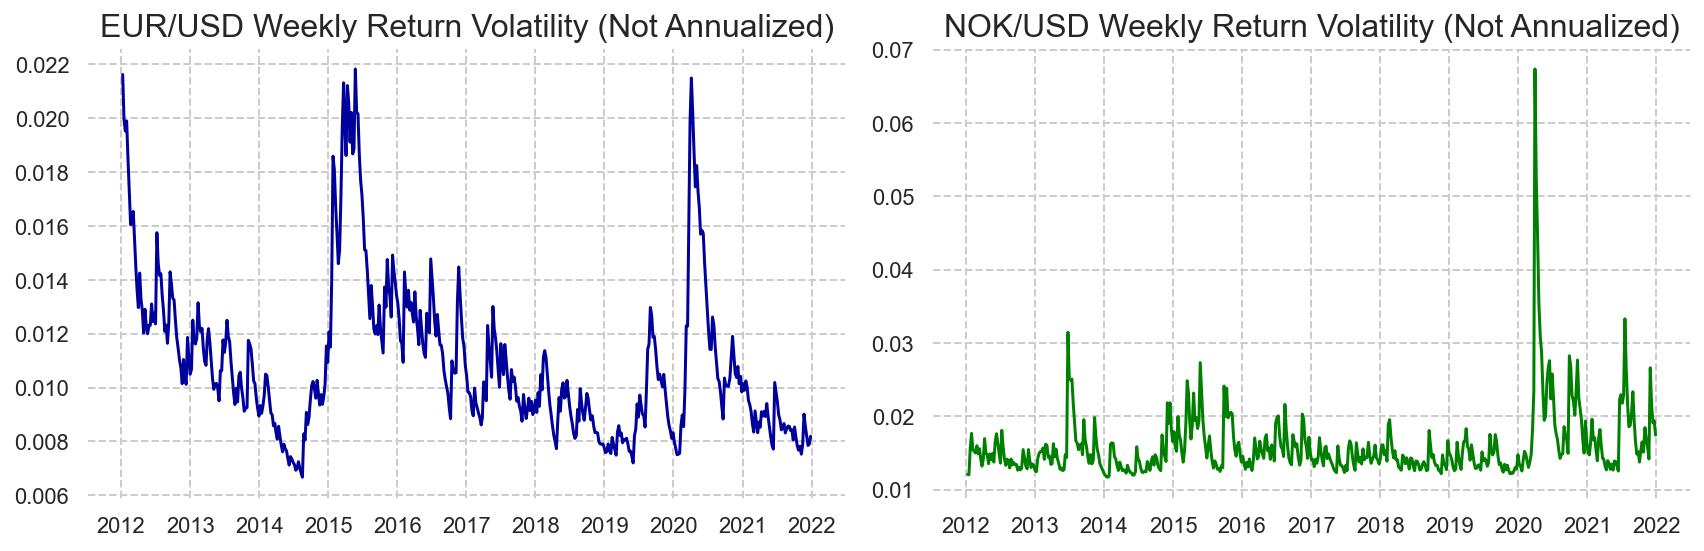

In [931]:
fig, axs = plt.subplots(1, 2)

axs[0].plot(eur_weekly_returns.index[1:], eur_garch)
axs[1].plot(nok_weekly_returns.index[1:], nok_garch, color='green')

axs[0].set_title('EUR/USD Weekly Return Volatility (Not Annualized)', fontsize=16)
axs[1].set_title('NOK/USD Weekly Return Volatility (Not Annualized)', fontsize=16)

axs[0].set_frame_on(False)
axs[1].set_frame_on(False)

fig.set_size_inches(12, 4)
plt.tight_layout()
plt.show()

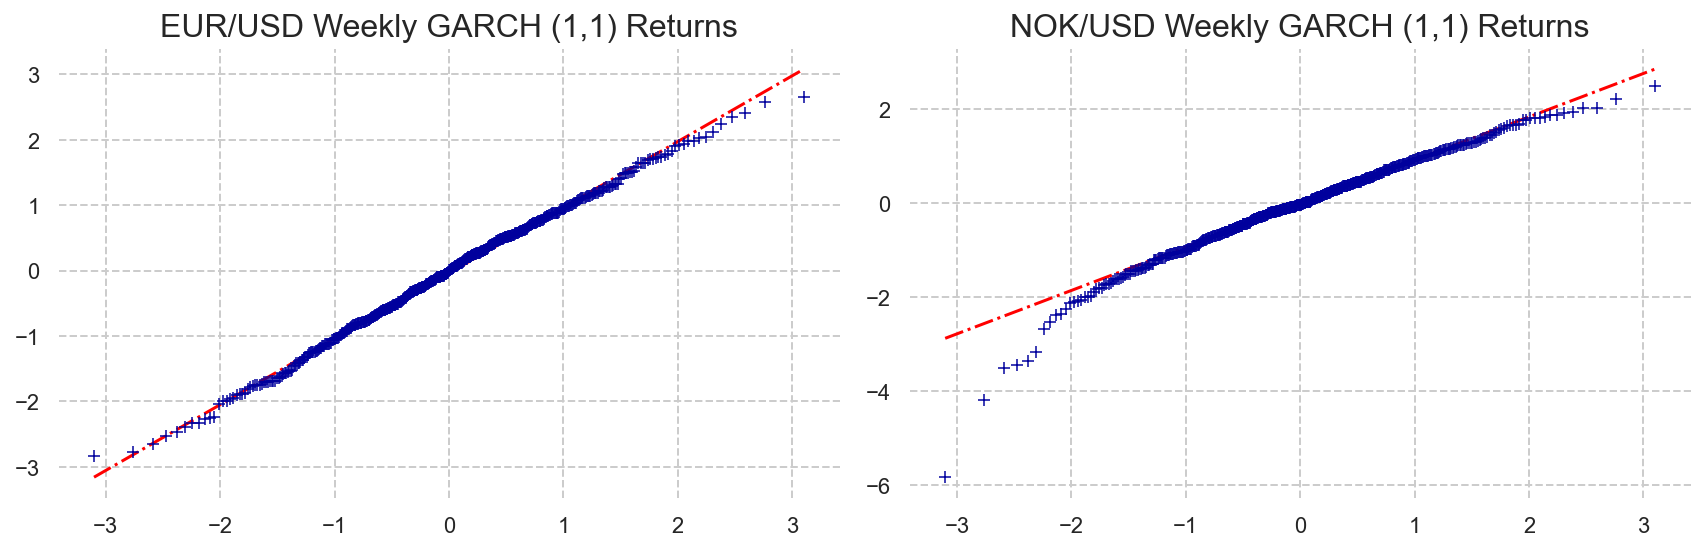

In [932]:
fig, axs = plt.subplots(1, 2)

qq_plot_normal(eur_normalized.to_list(), '', axs[0])
qq_plot_normal(nok_normalized.to_list(), '', axs[1])

axs[0].set_title('EUR/USD Weekly GARCH (1,1) Returns', fontsize=16)
axs[1].set_title('NOK/USD Weekly GARCH (1,1) Returns', fontsize=16)

axs[0].set_frame_on(False)
axs[1].set_frame_on(False)

fig.set_size_inches(12, 4)
plt.tight_layout()
plt.show()

---

### Copula Based Multivariate Distributions

In [942]:
import pandas as pd

eur_u1 = stats.norm.cdf(eur_normalized)
nok_u2 = stats.norm.cdf(nok_normalized)

transformed_sample = pd.DataFrame(zip(eur_u1, nok_u2), columns=['EUR/USD', 'NOK/USD'], index=eur_weekly_returns.index[1:])
transformed_sample

,EUR/USD,NOK/USD
Date,,
2012-01-09,0.461030,0.353301
2012-01-16,0.825824,0.964127
2012-01-23,0.895686,0.926587
2012-01-30,0.372859,0.468896
2012-02-06,0.660365,0.803749
...,...,...
2021-11-29,0.588154,0.511492
2021-12-06,0.509900,0.723152
2021-12-13,0.190910,0.874681


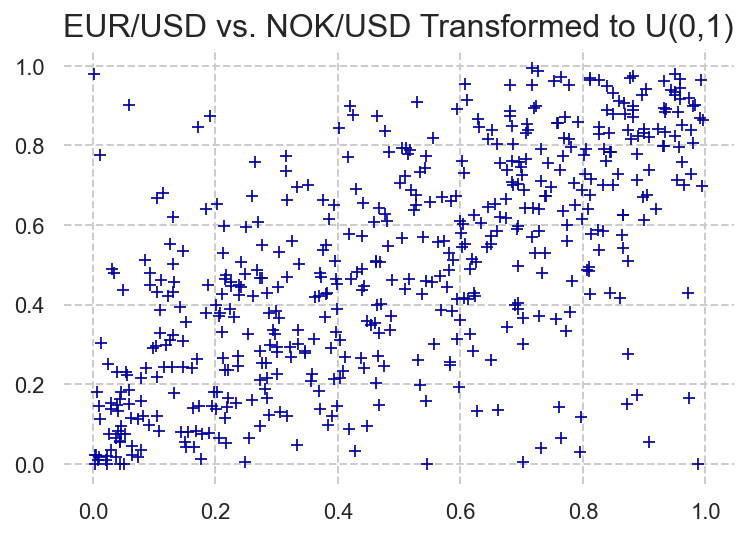

In [934]:
plt.scatter(eur_u1, nok_u2, marker='+', linewidths=0.85)
plt.box(False)
plt.title('EUR/USD vs. NOK/USD Transformed to U(0,1)', fontsize=16)
plt.show()

In [958]:
from numpy.linalg import inv
from scipy.special import gamma

def normal_copula_canonical(u1, u2, corr):
     u = np.array([[u1], 
                   [u2]])
     u = stats.norm.ppf(u)
     
     P = np.array([[1, corr],
     [corr, 1]])
     I = np.array([[1, 0],
     [0, 1]])
     
     return (1/np.sqrt(1-corr ** 2)) * np.exp(-0.5 * ((np.transpose(u) @ (inv(P)- I) @ u)[0][0]))

def students_t_copula_canonical(u1, u2, corr, nu):
     pass

---

Using the Copulae Package!

In [936]:
import copulae
#TODO: Examine to_pobs = True/False has something to do with my own MLE not working! 
#TODO: Checkout samples from GARCH(1,1). They are spooky!
normal_copula = copulae.GaussianCopula()
normal_copula.fit(transformed_sample)
print('Correlation coefficient of Normal Copula')
print(normal_copula.params[0])
print('Log-likelihood of Normal Copula')
print(normal_copula.log_lik(transformed_sample))

          EUR/USD     NOK/USD
count  521.000000  521.000000
mean     0.500000    0.500000
std      0.288398    0.288398
min      0.001916    0.001916
25%      0.250958    0.250958
50%      0.500000    0.500000
75%      0.749042    0.749042
max      0.998084    0.998084
Correlation coefficient of Normal Copula
0.6146793069357894
Log-likelihood of Normal Copula
120.6708483184982


In [937]:
student_copula = copulae.StudentCopula()
student_copula.fit(transformed_sample)
print('Correlation coefficient of Student Copula')
print(student_copula.params[1][0])
print('Degrees of Freedom coefficient in Student Copula')
print(student_copula.params[0])
print('Log-likelihood of Student Copula')
print(student_copula.log_lik(transformed_sample))

          EUR/USD     NOK/USD
count  521.000000  521.000000
mean     0.500000    0.500000
std      0.288398    0.288398
min      0.001916    0.001916
25%      0.250958    0.250958
50%      0.500000    0.500000
75%      0.749042    0.749042
max      0.998084    0.998084
Correlation coefficient of Student Copula
0.6627873211623084
Degrees of Freedom coefficient in Student Copula
4.391820704249035
Log-likelihood of Student Copula
150.33785597681464


In [938]:
clayton_copula = copulae.ClaytonCopula()
clayton_copula.fit(transformed_sample)
print('Clayton Parameter')
clayton_copula.params
print('Log-Likelihood of Clayton Copula')
clayton_copula.log_lik(transformed_sample)

          EUR/USD     NOK/USD
count  521.000000  521.000000
mean     0.500000    0.500000
std      0.288398    0.288398
min      0.001916    0.001916
25%      0.250958    0.250958
50%      0.500000    0.500000
75%      0.749042    0.749042
max      0.998084    0.998084
Clayton Parameter
Log-Likelihood of Clayton Copula


110.46370807096001

In [939]:
frank_copula = copulae.FrankCopula()
frank_copula.fit(transformed_sample)
print('Frank Parameter')
frank_copula.params
print('Log-Likelihood of Frank Copula')
frank_copula.log_lik(transformed_sample)

          EUR/USD     NOK/USD
count  521.000000  521.000000
mean     0.500000    0.500000
std      0.288398    0.288398
min      0.001916    0.001916
25%      0.250958    0.250958
50%      0.500000    0.500000
75%      0.749042    0.749042
max      0.998084    0.998084
Frank Parameter
Log-Likelihood of Frank Copula


145.52111695431415

In [940]:
gumbel_copula = copulae.GumbelCopula()
gumbel_copula.fit(transformed_sample)
print('Gumbel Parameter')
print(gumbel_copula.params)
print('Log-Likelihood of Gumbel Copula')
gumbel_copula.log_lik(transformed_sample)

          EUR/USD     NOK/USD
count  521.000000  521.000000
mean     0.500000    0.500000
std      0.288398    0.288398
min      0.001916    0.001916
25%      0.250958    0.250958
50%      0.500000    0.500000
75%      0.749042    0.749042
max      0.998084    0.998084
Gumbel Parameter
1.7445910340580517
Log-Likelihood of Gumbel Copula


124.32783020515438

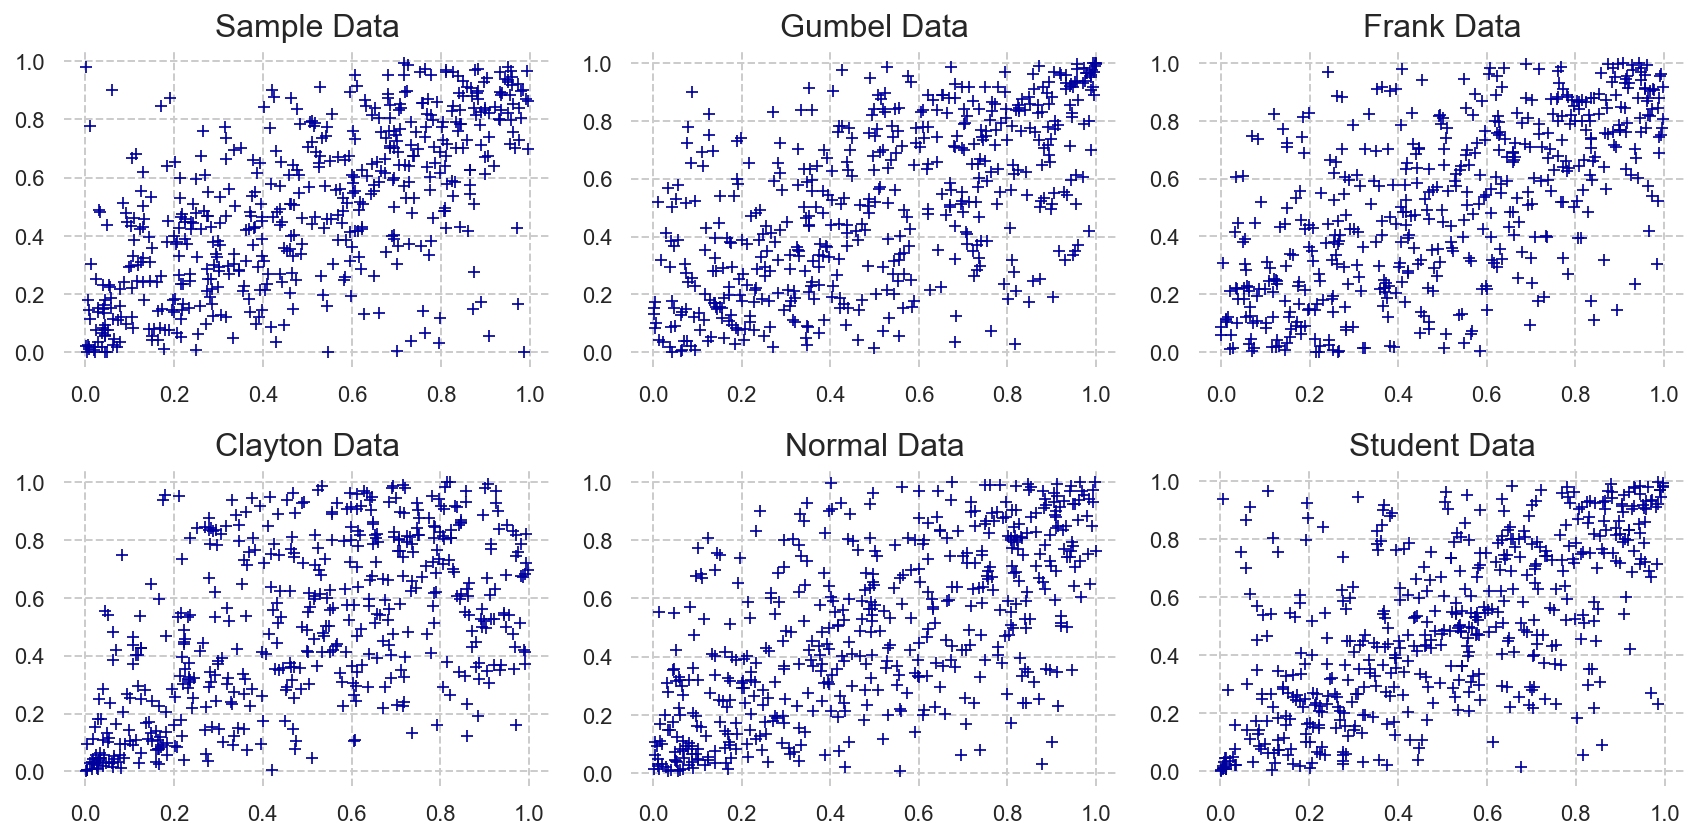

In [944]:
fig, axs = plt.subplots(2, 3)

sample_normal = normal_copula.random(500)
sample_student = student_copula.random(500)
sample_frank = frank_copula.random(500)
sample_clayton = clayton_copula.random(500)
sample_gumbel = gumbel_copula.random(500)

axs[0 ,0].scatter(transformed_sample['EUR/USD'], transformed_sample['NOK/USD'], marker='+', linewidths=0.85)
axs[0, 1].scatter(sample_gumbel['EUR/USD'], sample_gumbel['NOK/USD'], marker='+', linewidths=0.85)
axs[0, 2].scatter(sample_frank['EUR/USD'], sample_frank['NOK/USD'], marker='+', linewidths=0.85)
axs[1, 0].scatter(sample_clayton['EUR/USD'], sample_clayton['NOK/USD'], marker='+', linewidths=0.85)
axs[1, 1].scatter(sample_normal['EUR/USD'], sample_normal['NOK/USD'], marker='+', linewidths=0.85)
axs[1, 2].scatter(sample_student['EUR/USD'], sample_student['NOK/USD'], marker='+', linewidths=0.85)

axs[0, 0].set_frame_on(False)
axs[0, 1].set_frame_on(False)
axs[0, 2].set_frame_on(False)
axs[1, 0].set_frame_on(False)
axs[1, 1].set_frame_on(False)
axs[1, 2].set_frame_on(False)


axs[0, 0].set_title('Sample Data', fontsize=16)
axs[0, 1].set_title('Gumbel Data', fontsize=16)
axs[0, 2].set_title('Frank Data', fontsize=16)
axs[1, 0].set_title('Clayton Data', fontsize=16)
axs[1, 1].set_title('Normal Data', fontsize=16)
axs[1, 2].set_title('Student Data', fontsize=16)

fig.set_size_inches(12, 6)
plt.tight_layout()
plt.show()

---

In [1024]:
def plot_copula(copula, ax):
    X = np.linspace(0.01, 0.99)
    Y = np.linspace(0.01, 0.99)
    Z = []
    for i in range(len(X)):
        u1 = X[i]
        inner = []
        for j in range(len(Y)):
            u2 = Y[j]
            inner.append(copula.pdf([u1, u2]))
        Z.append(inner)
    X, Y = np.meshgrid(X, Y)
    Z = np.array(Z)

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.view_init(20, -75)
    ax.set_frame_on(False)

    # Remove gray panes in 3D plots. Replacing with a white color.
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')

    plot = ax.plot_surface(X, Y, Z , cmap='jet', edgecolor='none')

    return plot

def plot_copula_contour(copula, ax):
    X = np.linspace(0.01, 0.99)
    Y = np.linspace(0.01, 0.99)
    Z = []
    for i in range(len(X)):
        u1 = X[i]
        inner = []
        for j in range(len(Y)):
            u2 = Y[j]
            inner.append(copula.pdf([u1, u2]))
        Z.append(inner)

    X, Y = np.meshgrid(X, Y)
    Z = np.array(Z)

    ax.set_frame_on(False)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    plot = ax.contour(X, Y, Z)

    return plot

def copula_implied_pdf(x1, x2, copula):
     u1 = stats.norm.cdf(x1)
     u2 = stats.norm.cdf(x2)
     return copula.pdf([u1, u2]) * stats.norm.pdf(x1) * stats.norm.pdf(x2) 
    
def plot_implied_pdf(copula, ax):
    X = np.linspace(-3, 3)
    Y = np.linspace(-3, 3)
    Z = []
    for i in range(len(X)):
        x1 = X[i]
        inner = []
        for j in range(len(Y)):
            x2 = Y[j]
            inner.append(copula_implied_pdf(x1, x2, copula))
        Z.append(inner)
    
    X, Y = np.meshgrid(X, Y)
    Z = np.array(Z)

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.view_init(20, -75)
    ax.set_frame_on(False)

    # Remove gray panes in 3D plots. Replacing with a white color.
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')

    plot = ax.plot_surface(X, Y, Z , cmap='jet', edgecolor='none')

    return plot

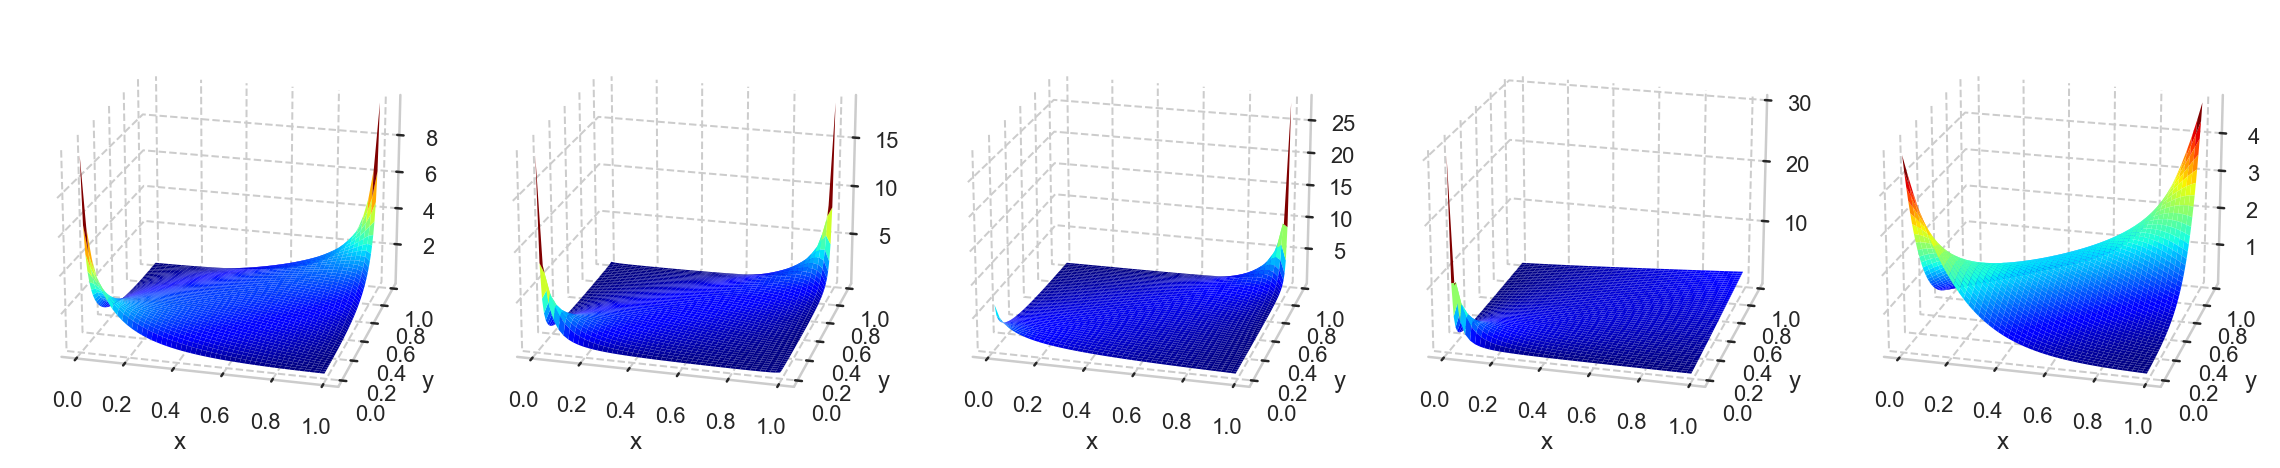

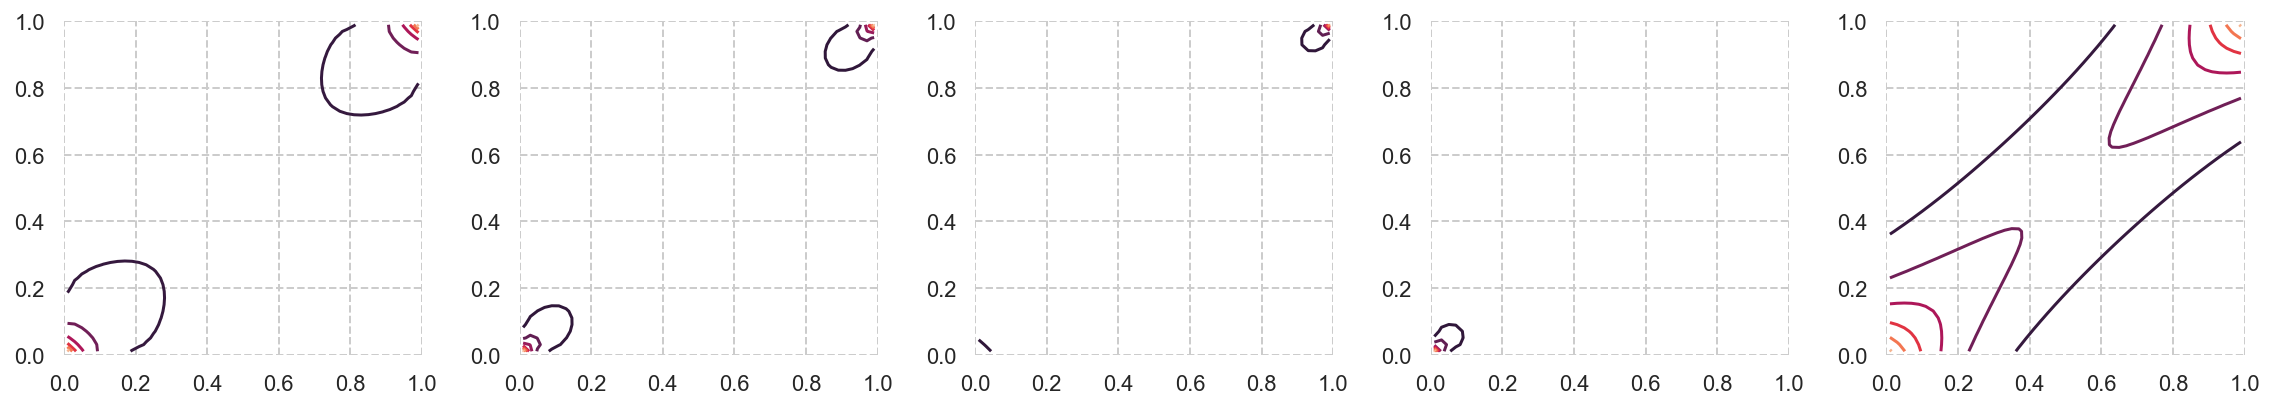

In [1026]:
fig, axs = plt.subplots(1,5, subplot_kw=dict(projection='3d'))

plot_copula(normal_copula, axs[0])
plot_copula(student_copula, axs[1])
plot_copula(gumbel_copula, axs[2])
plot_copula(clayton_copula, axs[3])
plot_copula(frank_copula, axs[4])

fig.set_size_inches(16, 6)
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1,5)

plot_copula_contour(normal_copula, axs[0])
plot_copula_contour(student_copula, axs[1])
plot_copula_contour(gumbel_copula, axs[2])
plot_copula_contour(clayton_copula, axs[3])
plot_copula_contour(frank_copula, axs[4])

fig.set_size_inches(16, 3)
plt.tight_layout()
plt.show()

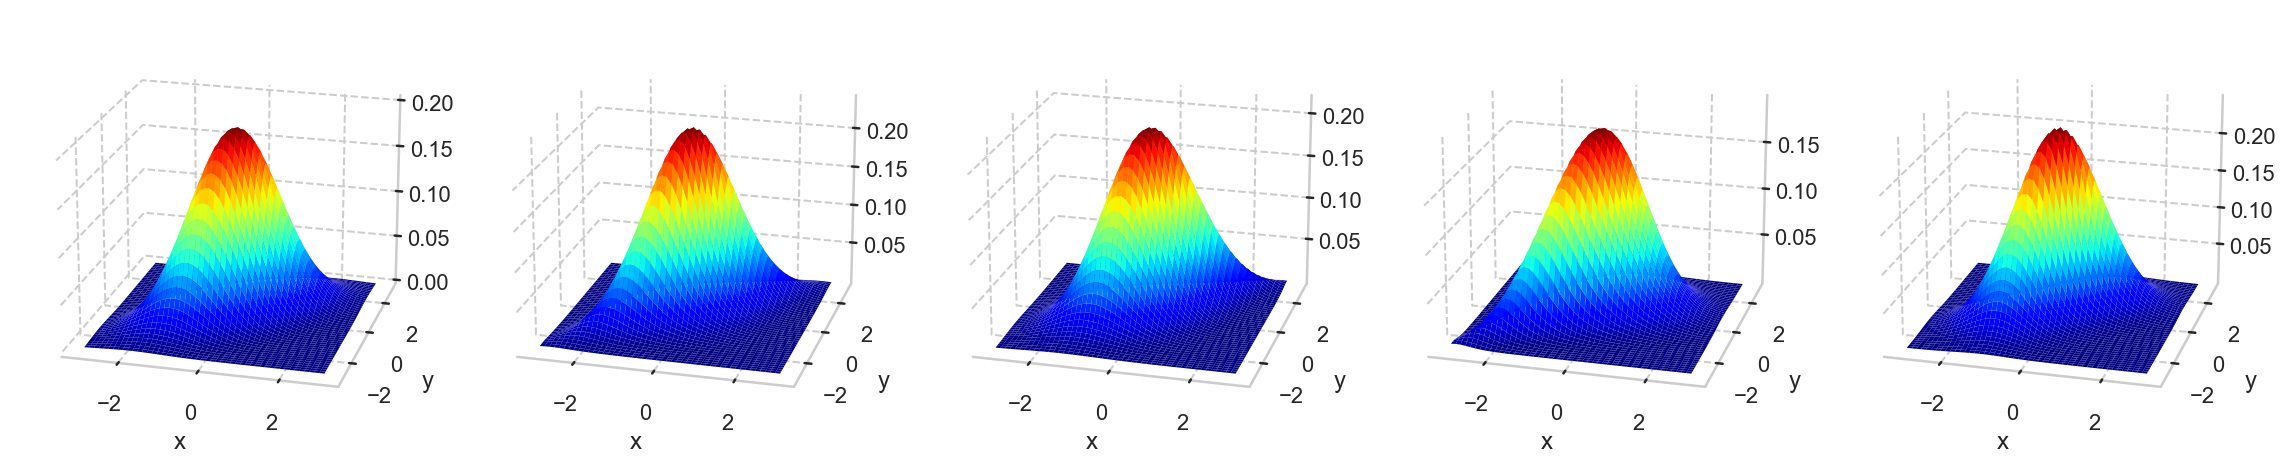

In [1021]:
fig, axs = plt.subplots(1,5, subplot_kw=dict(projection='3d'))

plot_implied_pdf(normal_copula, axs[0])
plot_implied_pdf(student_copula, axs[1])
plot_implied_pdf(gumbel_copula, axs[2])
plot_implied_pdf(clayton_copula, axs[3])
plot_implied_pdf(frank_copula, axs[4])

fig.set_size_inches(16, 6)
plt.tight_layout()
plt.show()

In [953]:
def copula_implied_pdf(x1, x2, corr):
     u1 = stats.norm.cdf(x1)
     u2 = stats.norm.cdf(x2)

     return normal_copula_canonical(u1, u2, corr) * stats.norm.pdf(x1) * stats.norm.pdf(x2) 

def log_likelihood(param, sample):
     
     likelihood = 0
     for i in range(len(sample[0])):
          u1 = sample[0][i]
          u2 = sample[1][i]
          likelihood = likelihood - np.log(normal_copula_canonical(u1, u2, param[0]))

     return likelihood

Let's transform our sample into uniform vairables, which will be used to fit the copula.

In [954]:
from scipy.optimize import minimize

cons_ewma = [{'type': 'ineq', 'fun': lambda x: x[0]},
             {'type': 'ineq', 'fun': lambda x: 1 - x[0]}]


sampleu1 = transformed_sample['EUR/USD'].apply(stats.norm.cdf).to_list()
sampleu2 = transformed_sample['NOK/USD'].apply(stats.norm.cdf).to_list()
sample = [sampleu1, sampleu2]


x0 = [0.52]
r = minimize(log_likelihood, x0, args=sample, constraints=cons_ewma)
r.x
r

     fun: -1156.1502720775475
     jac: array([-1.25585938])
 message: 'Optimization terminated successfully'
    nfev: 32
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([0.99649059])

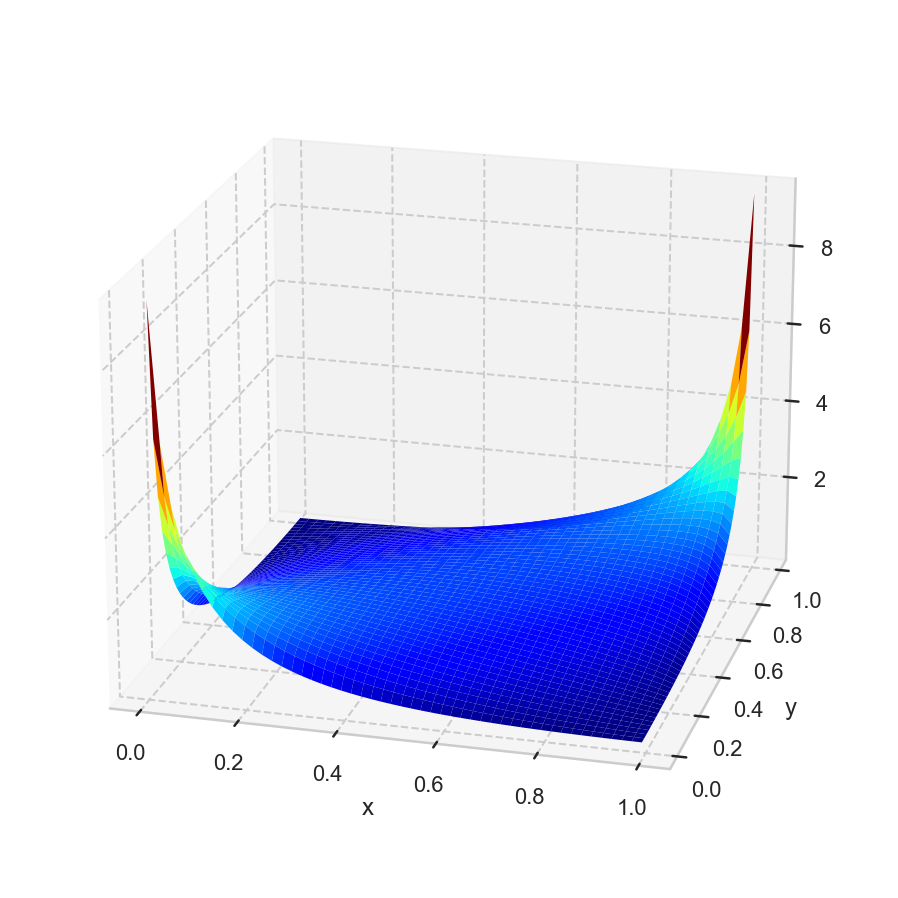

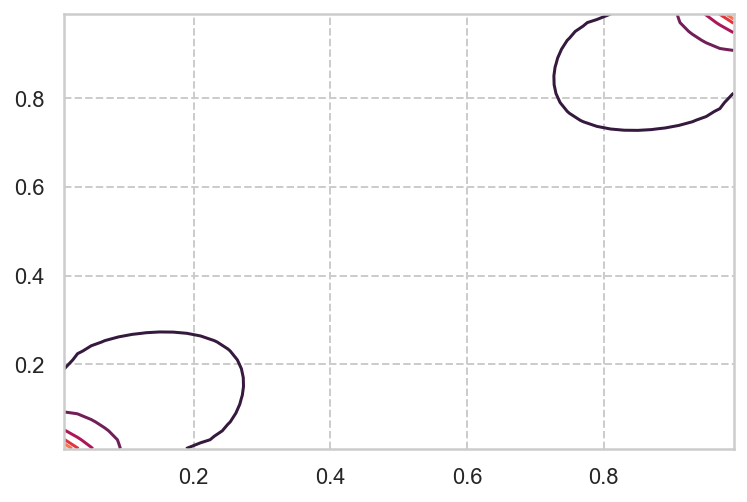

In [959]:
X = np.linspace(0.01, 0.99)
Y = np.linspace(0.01, 0.99)
Z = []
for i in range(len(X)):
    u1 = X[i]
    inner = []
    for j in range(len(Y)):
        u2 = Y[j]
        inner.append(normal_copula_canonical(u1, u2, 0.6))
    Z.append(inner)

X, Y = np.meshgrid(X, Y)
Z = np.array(Z)
fig = plt.figure()
axs[0, 0] = plt.axes(projection='3d')
axs[0, 0].plot_surface(X, Y, Z , cmap='jet', edgecolor='none')
axs[0, 0].set_xlabel('x')
axs[0, 0].set_ylabel('y')
fig.set_size_inches(8, 8)
axs[0, 0].view_init(20, -75)
plt.show()

plt.contour(X, Y, Z)
plt.show()

We want to change to a GARCH(1,1) model instead.

Implement Gaussian Copula. Correct MATLAB answer 0.6518

In [648]:
def log_likelihood_normal_copula(param, sample):
    likelihood = 0
    for i in range(len(sample[1])):
        u1 = sample[0][i]
        u2 = sample[1][i]
        likelihood = likelihood + np.log(normal_copula_canonical(u1, u2, param[0]))
    
    return -likelihood

In [669]:
cons = [{'type': 'ineq', 'fun': lambda x: x[0]},
        {'type': 'ineq', 'fun': lambda x: 1 - x[0]}]

sample = [u1_eur_garch, u2_nok_garch]

x0 = [0.99999]
r = minimize(log_likelihood_normal_copula, x0, args=u_samp, constraints=cons)
r.x
r

     fun: -2915.5195660282934
     jac: array([-19366158.70849609])
 message: 'Optimization terminated successfully'
    nfev: 2
     nit: 5
    njev: 1
  status: 0
 success: True
       x: array([0.99999])

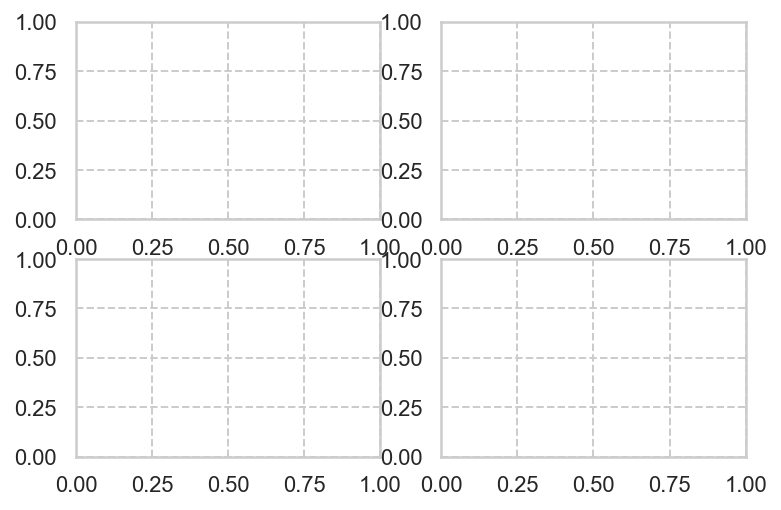

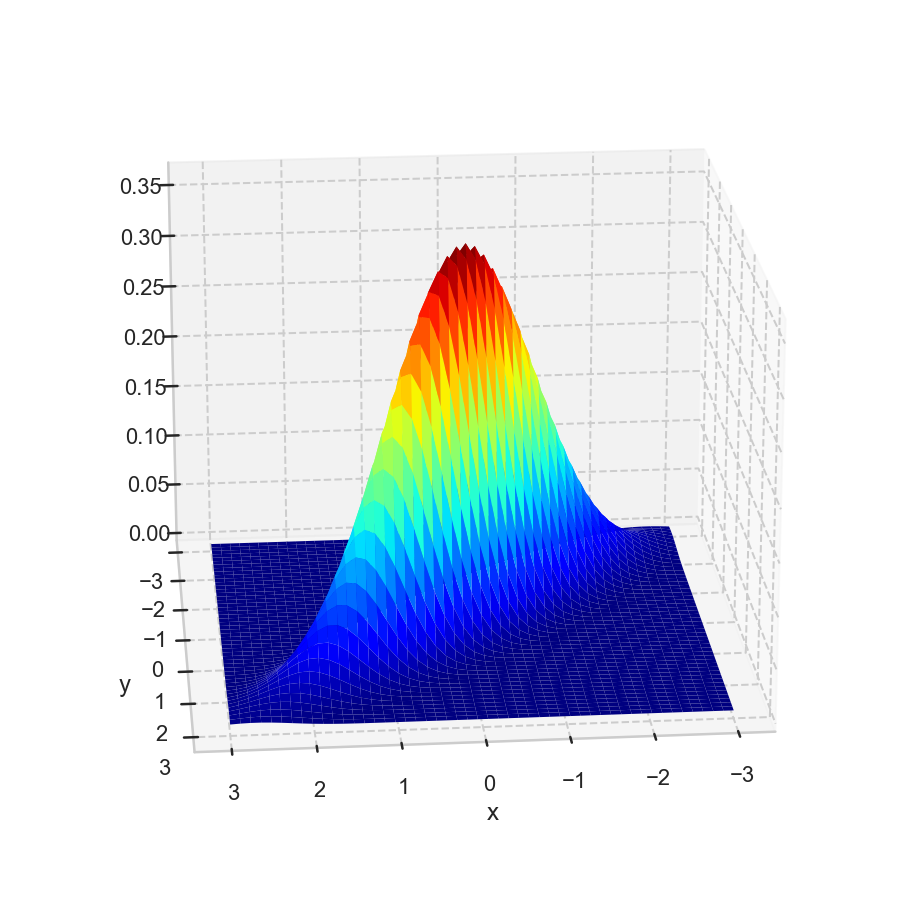

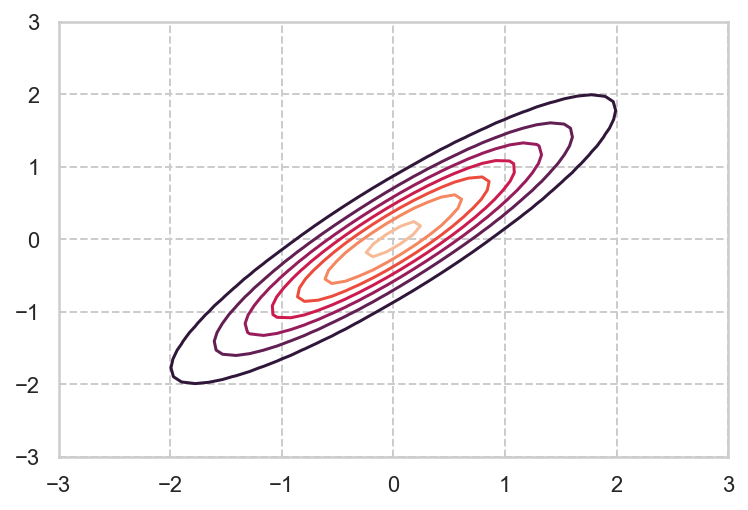

In [753]:
fig, axs = plt.subplots(2, 2)

X = np.linspace(-3, 3)
Y = np.linspace(-3, 3)
Z = []
for i in range(len(X)):
    u1 = X[i]
    inner = []
    for j in range(len(Y)):
        u2 = Y[j]
        inner.append(copula_implied_pdf(u1, u2, 0.9))
    Z.append(inner)

X, Y = np.meshgrid(X, Y)
Z = np.array(Z)
fig = plt.figure()
axs[0, 0] = plt.axes(projection='3d')
axs[0, 0].plot_surface(X, Y, Z , cmap='jet', edgecolor='none')
axs[0, 0].set_xlabel('x')
axs[0, 0].set_ylabel('y')
fig.set_size_inches(8, 8)
axs[0, 0].view_init(20, 85)
plt.show()

plt.contour(X, Y, Z)
plt.show()